# Exploratatory Quick analysis

This data set is meant to fuel a quick (~1 hour) analysis of what I can find in the data.  Specifically, only the columns date and car.count are relavent.  The data are synthetic. I'll try and comment on what I find as I go for notes for discussion over this project.

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import datetime
%matplotlib inline

### Initial processing
Read in the data, take a look at the two columns of interest (since we're only using two, should we extract into two vectors for ease of use?).

Probably going to keep with the dataframe since that's how I would do it typically.


In [201]:
df = pd.read_csv('data.csv', parse_dates=['date'], dtype={'car.count':np.float64})

The parse_dates makes sure that we get the date colun in datetime format (which makes some plotting and aggregating statistics easier).

### See what's in this file

In [202]:
df.head()

,date,day.of.week,car.count,weather
0,2010-01-01,friday,94.5,-0.1
1,2010-01-02,saturday,108.4,-2.4
2,2010-01-03,sunday,105.5,-0.5
3,2010-01-04,monday,109.6,-2.1
4,2010-01-05,tuesday,116.1,1.9


In [203]:
df.describe()

,car.count,weather
count,1799.000000,1826.000000
mean,171.297387,0.003395
std,34.716283,1.030690
min,50.900000,-3.400000
25%,147.550000,-0.700000
50%,174.700000,0.000000
75%,196.550000,0.700000
max,276.500000,3.600000


It looks like this file is car counts (probably in parking lots) given weather conditions and date (with day of the week provided). For this exercise, we only care about date and car count, so let's see how those correlate.

Also, it looks like there are days without car counts. Between 2010-2014, there should be 365x5 +1 (for the leap year) = 1826, so it appears that each day is represented in the table. We just need to figure out what to do with missing data.  

Options : 
* fill in with mean
* ignore those days (but this could make time-series analysis difficult later)
* average nearest values

In [204]:
# For now, I'm going to fill in missing data with the mean of that month. This should preserve large scale trends. Question 
# is how it will treat short term trends.
def groupMean(group):
    """Takes a group (from pandas groupby) and finds the mean."""
    group['car.count'] = group['car.count'].fillna(group['car.count'].mean())
    return group

# Apply the groupMean function to the dataframe
df = df.groupby([df.date.dt.year, df.date.dt.month]).transform(groupMean)

C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


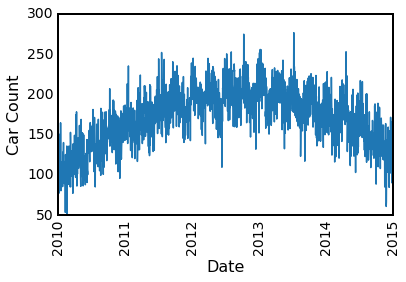

In [205]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['car.count'])
ax.set_xlim('2010-01-01','2015-01-01')
ax.set_xlabel("Date")
ax.set_ylabel("Car Count")
fig.autofmt_xdate(rotation=90, ha='center')

### Initial Impressions:

There appear to be at least two components to the trend of car counts as a function of date. The first is an overall (longterm) trend that *at first glance* is quadratic-ish. There is clearly structure on smaller scales.  To model this we clearly will need a combination of models (possibly a cyclic + baseline or a linear combination of cyclic functions).  Seeing how we see periodic terms on small scales, we probably don't want to assume that the large scale term is not also periodic, just on scales larger than our time frame.

### Let's take a closer look and see if we can make sense of the higher frequency term.

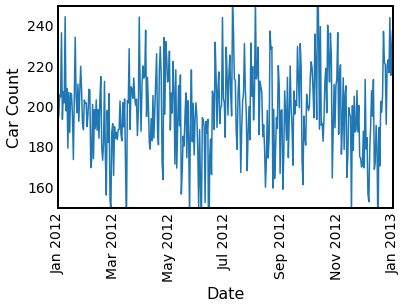

In [206]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['car.count'])
ax.set_xlim('2012-01-01','2013-01-01')
ax.set_ylim(150, 250)
ax.set_xlabel("Date")
ax.set_ylabel("Car Count")
fig.autofmt_xdate(rotation=90, ha='center')

Looking at this year-long slice of the data, my eye is drawn to a ~6 month period oscilation.  It's hard to tell visually if the "noise" between those terms is really noise or even higher frequency terms.

### A iterative approach. 

Let's remove the obvious trend (using a quadratic for now as we don't have enough information about the large scale trend to remove a periodic term robustly, nor really say it's periodic).

In [207]:
from sklearn.linear_model import LinearRegression

# Not the cleanest way, would rather it be generalized
day = [idx for idx, _ in enumerate(df['date'])]  # Since the df is sorted by date (I checked)
X = np.zeros((len(day), 3))
X[:,0] = 1  # Constant Term
X[:,1] = (day-np.amin(day)) / (np.amax(day)-np.amin(day))   # The day
X[:,2] = np.power(day,2)  # Quadratic Term
X[:,2] = (X[:,2]-np.amin(X[:,2])) / (np.amax(X[:,2])-np.amin(X[:,2]))


In [209]:
model = LinearRegression()
model.fit(X, df['car.count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

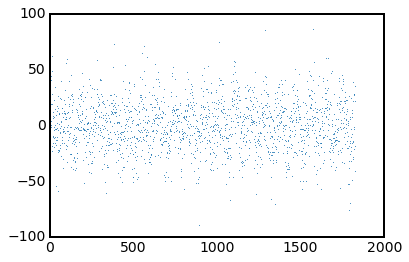

In [217]:
plt.plot(day, df['car.count']-model.predict(X), '.', markersize=2)
y = df['car.count']-model.predict(X)

Maximum Frequency Found at 0.010953 days


C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


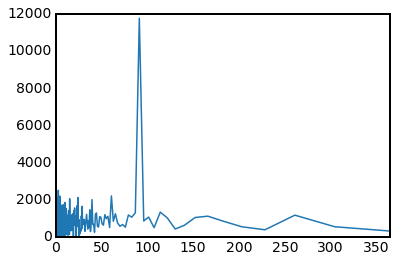

In [258]:
# Do an FFT of the residuals to see what frequencies dominate
fft = np.fft.fft(y)
freq = np.fft.fftfreq(np.array(day).shape[-1])

# We only care about the first half of the terms
freq = freq[0:len(y)/2]
fft = fft[0:len(y)/2]

plt.plot(1.0/freq, np.abs(fft))  # Plot in 1/freq to see days/cycle
plt.xlim(0, 365)

(maxfreq, maxamp) = max(zip(freq, np.abs(fft)), key=lambda x: x[1])

print("Maximum Frequency Found at %f days" % maxfreq)

Now, let's redo the linear regression including two periodic terms as well. (sin and cos)

In [259]:
# Not the cleanest way, would rather it be generalized
day = np.array([float(idx) for idx, _ in enumerate(df['date'])])  # Since the df is sorted by date (I checked)

X = np.zeros((len(day), 5))
X[:,0] = 1  # Constant Term
X[:,1] = (day-np.amin(day)) / (np.amax(day)-np.amin(day))   # The day
X[:,2] = np.power(day,2)  # Quadratic Term
X[:,2] = (X[:,2]-np.amin(X[:,2])) / (np.amax(X[:,2])-np.amin(X[:,2])) # Scale to between 0 and 1
X[:,3] = np.sin(2*np.pi*maxfreq*day)  # Sin term
X[:,4] = np.cos(2*np.pi*maxfreq*day)  # Cos Term


In [260]:
# Retrain the model
model = LinearRegression()
model.fit(X, df['car.count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

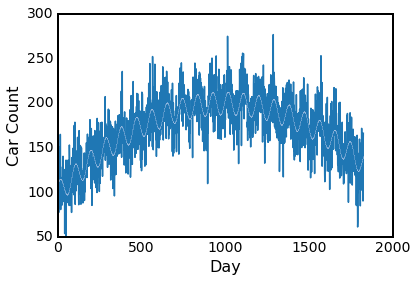

In [264]:
plt.plot(day, df['car.count'])
plt.plot(day, model.predict(X), '.', markersize=1)
plt.xlabel("Day")
plt.ylabel("Car Count")

(500, 1000)

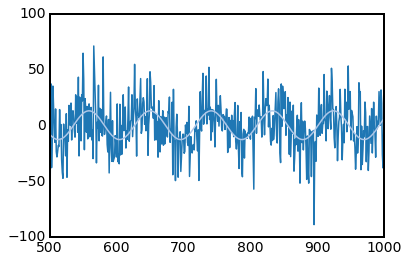

In [275]:
# Look at the residuals
X_sub = X.copy()
X_sub[:,3] = 0.0
X_sub[:,4] = 0.0
X_period = X.copy()
for ii in [0, 1, 2]:
    X_period[:,ii] = 0.0
plt.plot(day, df['car.count']-model.predict(X_sub))
plt.plot(day, model.predict(X)-model.predict(X_sub))
plt.xlim(500, 1000)
